# Deep Learning Modeling

Deep learning is great for time series data because we don't need to engineer features to represent the time-series data. Instead of using principal components or statistical features of the time series signals, we can feed the signals directly into a neural network and it will extract features of the data that are optimal for classifying the dataset. With a large number of features and samples, you'll see that deep learning is a more optimal approach compared to machine learning classifiers such as logistic regression or support vector machines.<br>

This notebook walks through how I built the deep learning model using one cross fold of leave one subject out cross validation. The true leave one subject out procedure is in the IMU_gait_speed_classification_DL_modeling.ipynb notebook that I set up to used in Google Colab. To speed up training time, instead of training on each crossfold locally, I set up that notebook to use with GPUs on Colab. Before running that notebook, go to Edit > Notebook Settings > Select GPU as the Hardware Accelerator. 

## Table of Contents
1) Importing data testing deep learning model on one subject (i.e., one crossfold)<br>
2) Developing code for training DL model using leave one subject out cross validation.<br>
* Note: for the second part, I moved the code to IMU_gait_speed_classification_DL_modeling.ipynb to use with Google Colab.

### Step 1: Importing data and testing deep learning framework

In [973]:
#import data
data = pd.read_csv(os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',', index_col=0)
data

,subject_ID,speed,trial,0,1,2,3,4,5,6,...,91.5,92.5,93.5,94.5,95.5,96.5,97.5,98.5,99.5,100.5
0,s00,c,1,-0.785499,0.048891,0.887749,-1.538448,-1.498763,-1.410166,-0.755886,...,-2.145579,-2.024937,-1.742317,-1.431725,-1.008357,-0.604923,-0.200607,0.109992,0.435033,0.512502
1,s00,c,1,-0.515080,0.186497,-0.137469,-1.348494,-1.103039,-1.753461,-0.907637,...,-2.279677,-2.288844,-2.218154,-2.053697,-1.721983,-1.363308,-0.914097,-0.491090,-0.109573,0.170197
2,s00,c,1,-0.466326,0.008363,-1.091427,-0.984386,-0.692273,-1.275159,-1.092490,...,-2.037255,-1.745499,-1.345704,-0.917662,-0.529495,-0.130319,0.190606,0.430144,0.565811,0.613459
3,s00,c,1,-0.748953,-0.001351,-0.078294,-1.676746,-1.504785,-1.525641,-0.497352,...,-2.406615,-2.299132,-2.109052,-1.845726,-1.441080,-1.010931,-0.548103,-0.129683,0.194304,0.456805
4,s00,c,1,-0.721953,0.351601,-0.187786,-1.395962,-1.289673,-1.824039,-0.796538,...,-2.253681,-2.125113,-1.888527,-1.550835,-1.111220,-0.669228,-0.214431,0.221778,0.508470,0.793325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,s22,s,6,-0.867486,0.431548,-0.170909,-1.310338,-1.955833,-2.225970,-1.816291,...,-1.580561,-0.729205,0.184986,0.711433,0.808552,0.510799,0.502856,0.630475,1.096373,1.175347
29,s22,s,6,-0.793640,0.247581,-0.642847,-1.456182,-1.824447,-1.978281,-1.783781,...,-3.016800,-2.433813,-1.366641,-0.145324,0.587915,0.631695,0.630369,0.625611,0.925510,1.033270
30,s22,s,6,-0.821355,0.569941,-0.334288,-1.263533,-1.660690,-1.896455,-2.131514,...,-3.750511,-3.434145,-2.316985,-0.825054,0.702685,1.171039,1.098561,0.792446,0.870793,0.931981
31,s22,s,6,-0.768815,0.594295,-0.188425,-1.111532,-1.500936,-1.686423,-1.908461,...,-2.444916,-2.133775,-1.497435,-0.597643,0.213426,0.566586,0.556478,0.510004,0.757065,1.063219


In [974]:
x_train = data.loc[data['subject_ID'] != 's00'].drop(['subject_ID', 'speed', 'trial'], axis=1)
x_test = data.loc[data['subject_ID'] == 's00'].drop(['subject_ID', 'trial', 'speed'], axis=1)
y_train = data.loc[data['subject_ID'] != 's00']['speed']
y_test = data.loc[data['subject_ID'] == 's00']['speed']

Reshape data like: X_train.reshape(num_of_examples, num_of_features, num_of_signals) See https://stackoverflow.com/questions/50005092/how-to-build-1d-convolutional-neural-network-in-keras-python

In [975]:
X_train = np.asarray(x_train)
X_train = X_train.reshape(X_train.shape[0], 101, 6)

In [976]:
X_test = np.asarray(x_test)
X_test = X_test.reshape(X_test.shape[0], 101, 6)

In [977]:
encoder = LabelEncoder()
encoder.fit(y_train.values)

y_train = encoder.transform(y_train.values)
y_test = encoder.transform(y_test.values)

#Convert y_train and y_test to categorical variables 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [978]:
#display shapes of training and testing data to confirm that dimensions match
print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print("----------------------------")
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (11489, 101, 6)
Y train: (11489, 3)
----------------------------
X test: (613, 101, 6)
Y test: (613, 3)


In [979]:
len(encoder.classes_)

3

In [936]:
#create deep learning architecture

model = Sequential()
#since we only have a 1D vector, only 1D convolutional layers are needed
model.add(Conv1D(filters=16, kernel_size=2, input_shape=(101, 6)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 100, 16)           208       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 49, 32)            1056      
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 24, 32)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 23, 64)            4160      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 11, 64)          

In [937]:
#compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

In [946]:
#test neural network
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/200
180/180 [==============================] - 2s 12ms/step - loss: 0.1125 - accuracy: 0.9566 - val_loss: 0.2522 - val_accuracy: 0.8940
Epoch 2/200
180/180 [==============================] - 2s 12ms/step - loss: 0.1113 - accuracy: 0.9573 - val_loss: 0.2440 - val_accuracy: 0.8972
Epoch 3/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1092 - accuracy: 0.9589 - val_loss: 0.2182 - val_accuracy: 0.8989
Epoch 4/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1179 - accuracy: 0.9544 - val_loss: 0.2566 - val_accuracy: 0.8858
Epoch 5/200
180/180 [==============================] - 2s 11ms/step - loss: 0.1180 - accuracy: 0.9533 - val_loss: 0.2712 - val_accuracy: 0.8858
Epoch 6/200
 81/180 [============>.................] - ETA: 1s - loss: 0.1214 - accuracy: 0.9554

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

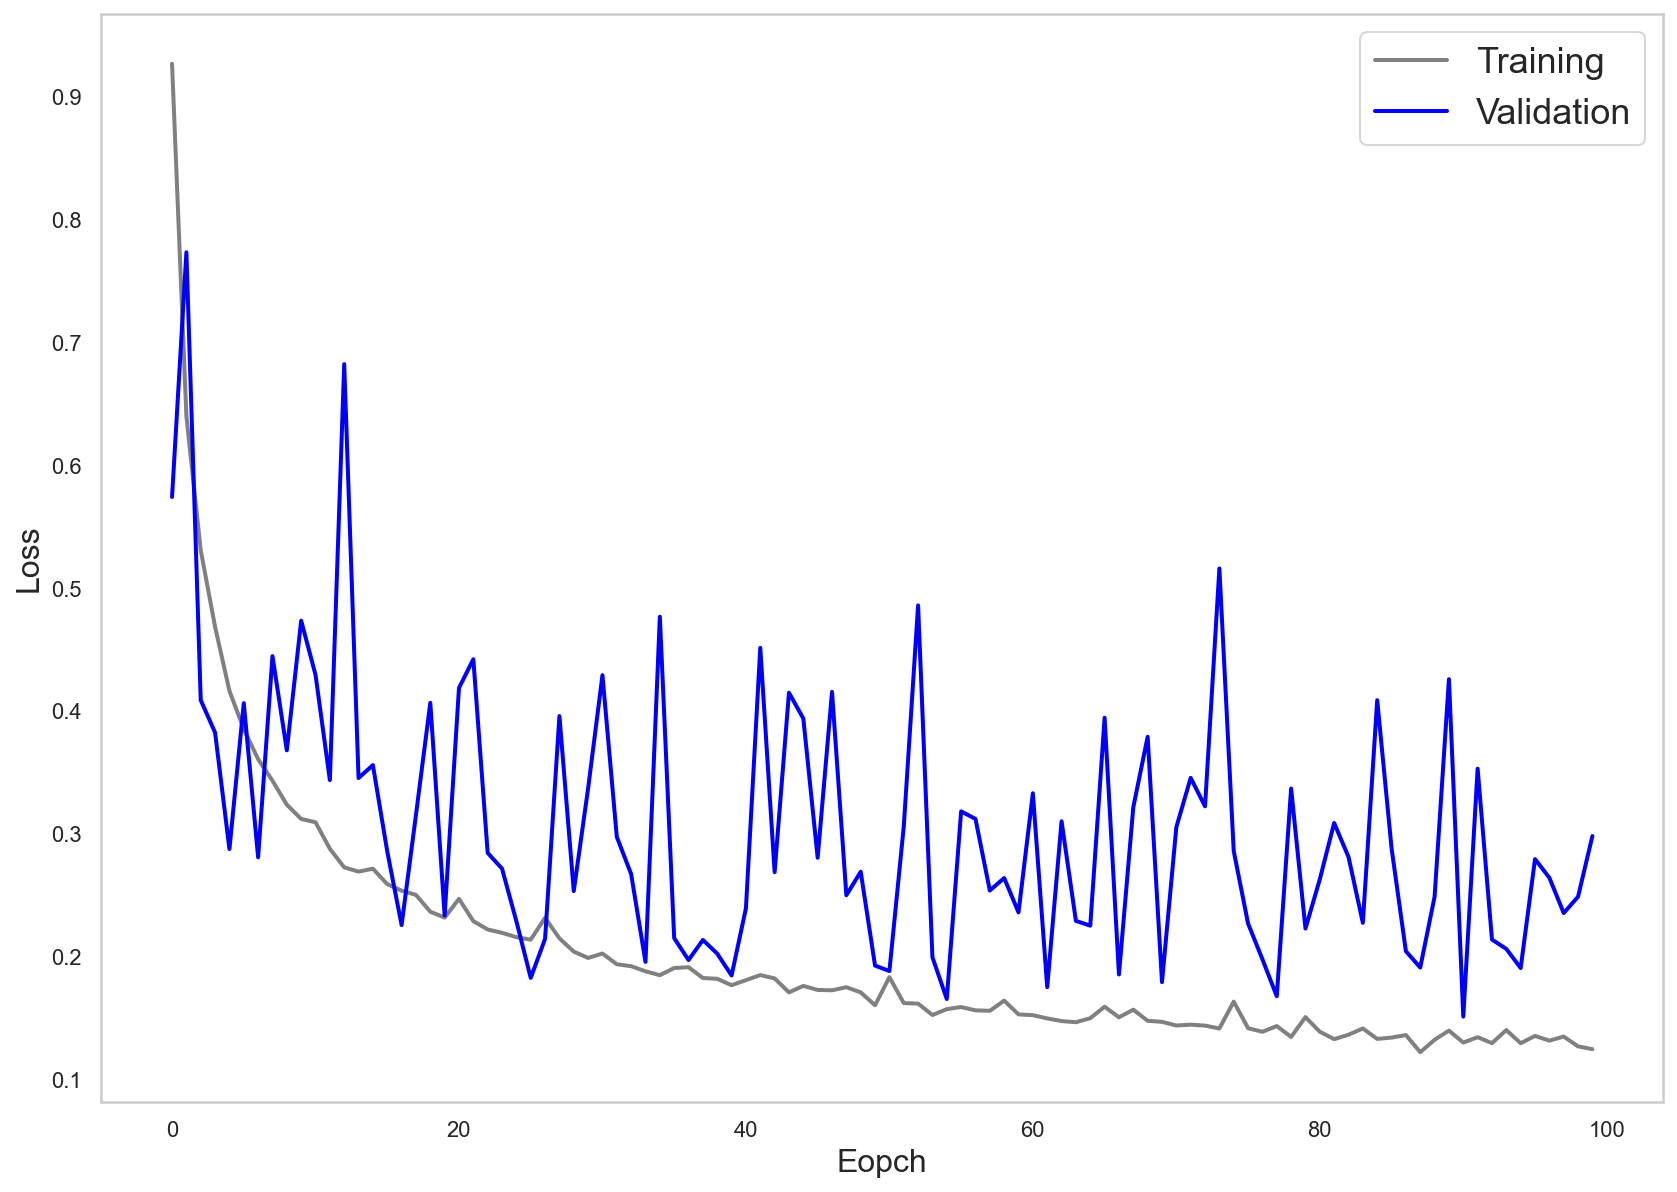

In [939]:
plt.figure(figsize=[14,10])
plt.plot(history.history['loss'], 'gray', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

Text(0, 0.5, 'Loss')

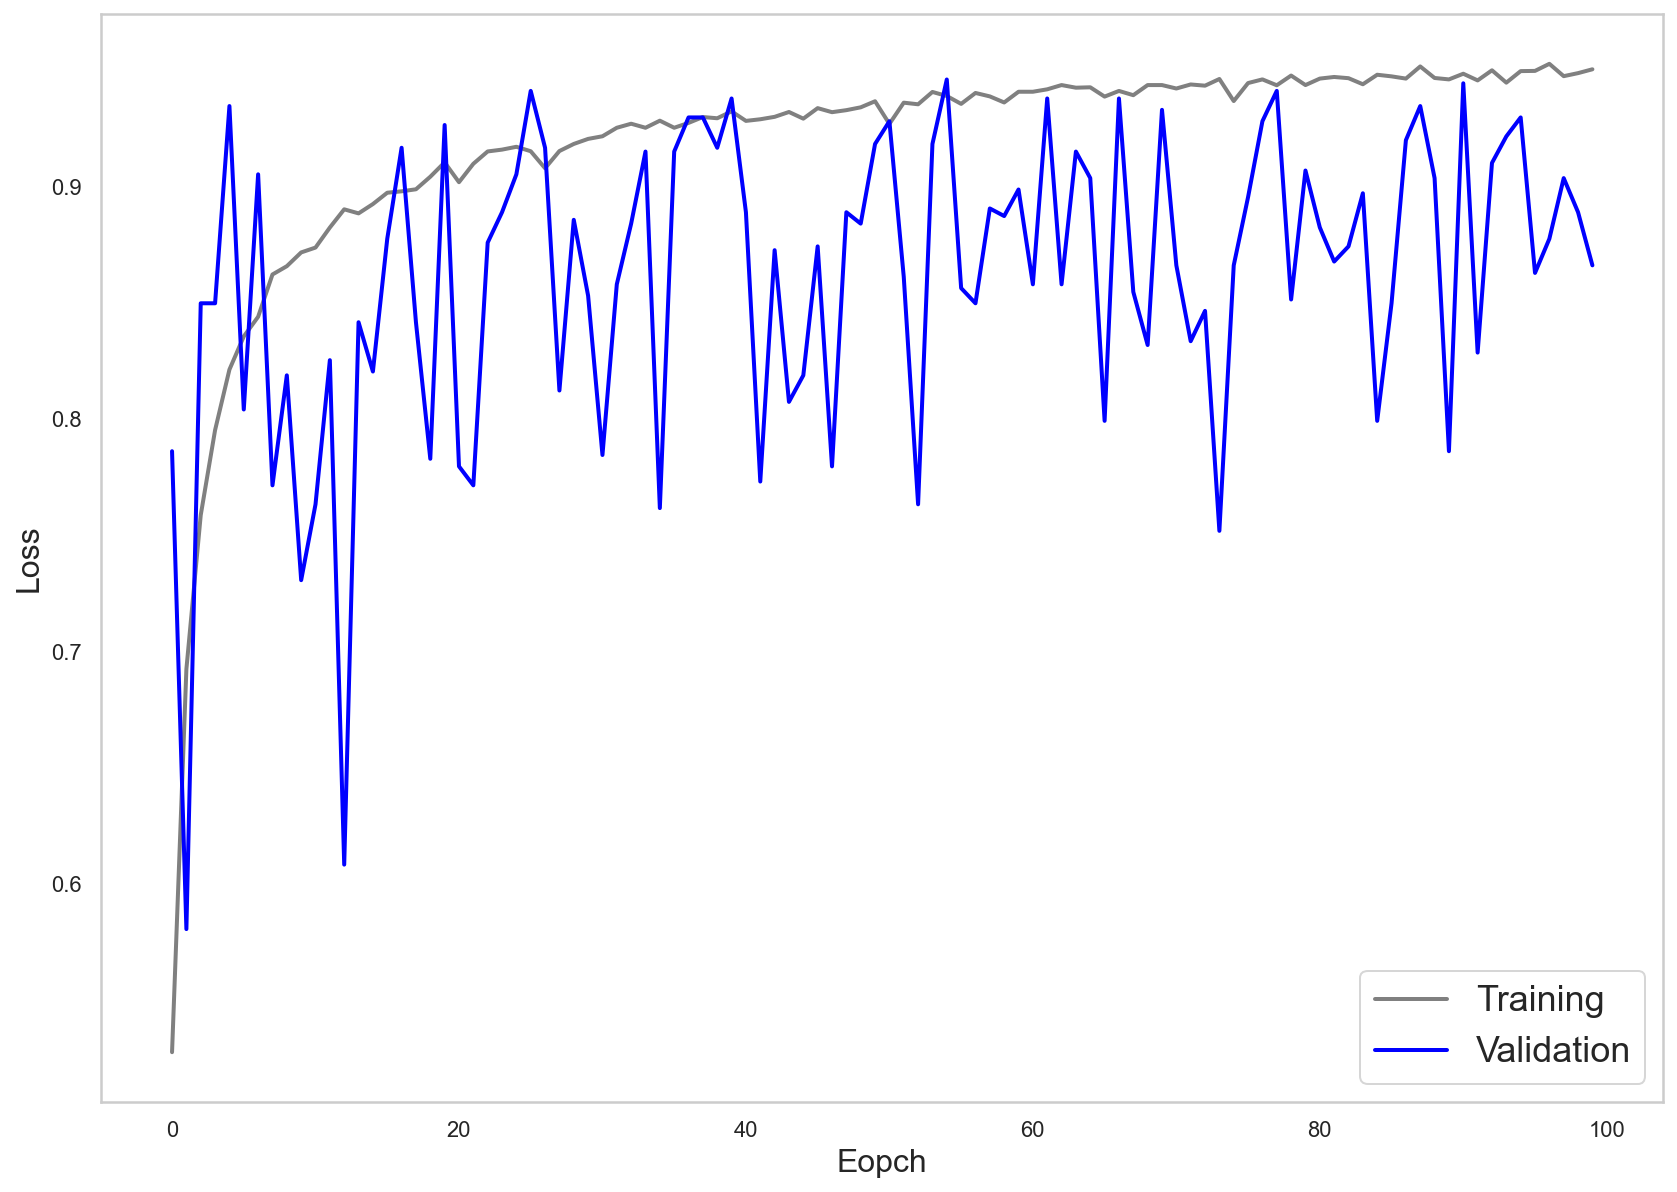

In [940]:
plt.figure(figsize=[14,10])
plt.plot(history.history['accuracy'], 'gray', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

### Step 2: Fitting Deep Learning Model with Leave One Subject Out Cross Validation

Once the deep learning model is tested on a simple split between training and testing data, we can now move towards the leave one subject out cross validation approach.<br>

Leave one subject out cross validation trains the model on all observations from n-1 subjects, and tests the model on the remaining subject. This is repeated n times until all subjects have been tested by the model. To evaluate the performance of the model, you can calculate the average accuracy over all crossfolds/subjects)<br>

I imported this section of the notebook into Google Colab so I could train the network with their GPU for better efficiency. See IMU_gait_speed_classification_DL_modeling.ipynb

In [972]:
#deep learning architecture

model = Sequential()
#since we only have a 1D vector, only 1D convolutional layers are needed
model.add(Conv1D(filters=16, kernel_size=2, input_shape=(101, 6)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 100, 16)           208       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 50, 16)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 49, 32)            1056      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 24, 32)            0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 23, 64)            4160      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 11, 64)          

In [966]:
#compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

In [967]:
#import data
data = pd.read_csv(os.getcwd()+'/strides/ML_data/R_variables_all_std.csv', sep=',', index_col=0)

In [971]:
#get a list of all subjects
all_subjects = data['subject_ID'].unique()

#create an empty list to store accuracy in
max_accuracy_list = []
average_accuracy_list = []
average_accuracy_list_third = []

#loop over all conditions
for idx, subject_ID in enumerate(all_subjects):
    
    #assign testing and training data
    x_train = data.loc[data['subject_ID'] != subject_ID].drop(['subject_ID', 'speed', 'trial'], axis=1)
    x_test = data.loc[data['subject_ID'] == subject_ID].drop(['subject_ID', 'trial', 'speed'], axis=1)
    y_train = data.loc[data['subject_ID'] != subject_ID]['speed']
    y_test = data.loc[data['subject_ID'] == subject_ID]['speed']
    
    #convert training and testing data to arrays and reshape into (num_of_examples, num_of_features, num_of_signals)
    X_train = np.asarray(x_train)
    X_train = X_train.reshape(X_train.shape[0], 101, 6)
    X_test = np.asarray(x_test)
    X_test = X_test.reshape(X_test.shape[0], 101, 6)
    
    #encode training and testing labels (switch from letters to one hot encoding)
    encoder = LabelEncoder()
    encoder.fit(y_train.values)
    y_train = encoder.transform(y_train.values)
    y_test = encoder.transform(y_test.values)
    #Convert y_train and y_test to categorical variables 
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fit model
    history = model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_test, y_test), shuffle=True)
    
    #append max accuracy over all epochs
    max_accuracy_list.append(max(history.history['val_accuracy']))
    #append mean accuracy over all epochs
    average_accuracy_list.append(mean(history.history['val_accuracy']))
    #append mean accuracy over final third of epochs
    average_accuracy_list_third.append(mean(history.history['val_accuracy'][66::]))

#get average of accuracies over all cross folds
mean_max_accuracy = mean(max_accuracy_list)
mean_average_accuracy = mean(average_accuracy_list)
mean_average_accuracy_third = mean(average_accuracy_list_third)

print('Average Max Accuracy: ', mean_max_accuracy)
print('Mean Average Accuracy: ', mean_average_accuracy)
print('Mean Average Accuracy Over Final Third of Epochs: ', mean_average_accuracy_third)

Epoch 1/2
180/180 [==============================] - 2s 12ms/step - loss: 0.3361 - accuracy: 0.8610 - val_loss: 0.5446 - val_accuracy: 0.7193
Epoch 2/2
180/180 [==============================] - 2s 11ms/step - loss: 0.3393 - accuracy: 0.8577 - val_loss: 0.4548 - val_accuracy: 0.7848
Epoch 1/2
181/181 [==============================] - 2s 12ms/step - loss: 0.3158 - accuracy: 0.8750 - val_loss: 0.2686 - val_accuracy: 0.9097
Epoch 2/2
181/181 [==============================] - 2s 12ms/step - loss: 0.3043 - accuracy: 0.8744 - val_loss: 0.2852 - val_accuracy: 0.8989
Epoch 1/2
182/182 [==============================] - 2s 12ms/step - loss: 0.2882 - accuracy: 0.8858 - val_loss: 0.3832 - val_accuracy: 0.8386
Epoch 2/2
182/182 [==============================] - 2s 12ms/step - loss: 0.2869 - accuracy: 0.8798 - val_loss: 0.5337 - val_accuracy: 0.7379
Epoch 1/2
180/180 [==============================] - 2s 13ms/step - loss: 0.2890 - accuracy: 0.8856 - val_loss: 0.1016 - val_accuracy: 0.9816
Epoch 